# Use version control (Git), and automatically visualize my favorite database
Author: Nikolaj Pagh Kristensen

Background: My two favorite databases that I often use in my project contains information T-cell targets and T-cell receptor(TCR) sequences. These are: IEDB(http://www.iedb.org/) and VDJdb (https://vdjdb.cdr3.net/ named after the V, D and J segments of the TCR). I wish to create a script that automatically imports a subset of the database that is relevant to me, calculates summary statistics for my favorite groups of T-cells along with some visualization. Overall, this script should automatically give me an overview of the database independently of downloading excel-sheets from the website itself

What I aim to do:
1. Create a github repository",
1. Create the necessary initial files according to public guides (https://kbroman.org/github_tutorial/pages/init.html)
1. Use an API to download a relevant dataset from IEDB. This will be a bit challenging as I have little understanding of SQL or postreSQL.
1. Visualize the following:
    1. Distribution of sequence lengths for epitopes within the database restricted to MHC I. 

Other questions: 
   - Which viruses do the epitopes from the IEDB database originate from? At what frequency are their epitopes present within the downloaded dataset?
   - Which HLA do the epitopes bind to? At what frequency are each HLA annotated within the downloaded dataset?
   - What is the typical epitope length for top 5 most frequenct annotated HLAs within the database?
   - What viral antigens are frequently targeted by T cells within the database?
   - Are epitopes that bind HLA-A fundamentally different than epitope that bind HLA-B? Are epitopes that can bind both unqiue from the two other groups?

What I managed to do: 
*I managed to complete objective 1-4, but have chosen to limit the amount of time spend on plotting, as I already have a good understanding of the tools I can use in R*

Extra things:
1. Do something similar but with VDJdb
2. Perform sequence analysis of epitopes. Generate clusters of epitopes based on sequence similarity.

# Start a new github repository and start keeping track of versions by using tags
From the terminal I will execute the following,
1. Make new dirs (Python_projects and Python_projects/Course_work),
2. Initialize git by typing git init within the Python_course_report folder:`git init`,
3. Generate a README file (Markdown) as well as a .gitingore `touch .gitignore`,
1. Use `git add` to add files to the staging area
1. Use `git commit -m` to commint the stagining area together with a required comment

I double cheched my commit by using `git log`

Version numbering is a good practice: https://stackoverflow.com/questions/37814286/how-to-manage-the-version-number-in-git
    The general nomenclature is: `[major].[minor].[patch]-[build/beta/rc]`

1. Use initial `git tag -a v0.1.0 -m "Initial version"`
2. inspect tags using `git describe` succesfully returned a list of versions for the git repo

Note, tags appear to be mostly used for programs that are finished/published where one need to update it slightly.


# Scrape IEDB for data
IEDB released an API to collect information directly on the command line or in your Jupyter notbook. The API postREST platform (https://postgrest.org/en/stable/), which has a list of functions and operators that are useful to know (https://postgrest.org/en/v7.0.0/api.html. For more information how it was implemented in the IEDB API see: https://query-api.iedb.org/docs/swagger/ and seek help here: https://help.iedb.org/hc/en-us/articles/4402872882189-Immune-Epitope-Database-Query-API-IQ-API-

## Core endpoints from the API
IEDB have multiple endpoints. See the full list here: https://postgrest.org/en/v7.0.0/api.html. I will focus on: 

    epitope_search    
`epitope_searh` Contains information on amino acid sequences found within the database, who found them (authors, article references), and to what HLA they're restricted to
    
And maybe: 

    tcell_search (assays) 

Depending on time. 

A good example is found in file: use_case_1a.ipynb. As this is not my example and mostly for my own undersrtanding, I have chosen to hide it with .gitignore in the git repo.
***
## Downloading information on a single epitope in a tabular format
This is described in the tutorial: use_case_1a.ipynb. 
<br>Let's start with the necessary packages:

In [1]:
import requests
import json
import pandas as pd
from io import StringIO

Let's define the url that we will be sending requests to. 

In [2]:
base_url='https://query-api.iedb.org'

The user-case recommends a function to print the CURL command given a request:

In [3]:
# funciton to print the CURL command given a request
    #req is the request, a request
def print_curl_cmd(req):
    url = req.url
    print("This is the request url used with the curl cmd:") #My addition
    print("curl -X 'GET' '" + url + "'")

The first search should be *simple*, meaning that we will download all information related to a single epitope (my favorite epitope)
1. Define database/table that I wish to look up (e.g epitope_search)
1. Define the rows that I wish to keep (filtering)
1. Define the columns that I wish to keep (selecting / filtering on columns)
1. Define the full url of the table that we search for
4. fetch the result by parsing the full URL to requests.get or diretly to curl. 

### First, try to look up a single favorite epitope

In [4]:
my_favorite_epitope = "HPVGEADYFEY"  #HPVGEADYFEY is one of the longest, dominant epitopes on B*3501
search_params={ 'linear_sequence': 'eq.'+my_favorite_epitope} #eq. here is a special postREST operator it abbreviates "equal"
table_name='epitope_search'
full_url=base_url + '/' + table_name
result = requests.get(full_url, params=search_params)
print_curl_cmd(result)

This is the request url used with the curl cmd:
curl -X 'GET' 'https://query-api.iedb.org/epitope_search?linear_sequence=eq.HPVGEADYFEY'


We have the results. Inspect it:

    what type is it?

In [5]:
print("The downloaded file is of type", type(result))

The downloaded file is of type <class 'requests.models.Response'>


We need to transform *class: 'requests.models.Response'* into something useful. The IEDB API Tutorial recommends turning into a data frame right away

In [6]:
#Converts the request (json object?) to a pandas dataframe. 
df = pd.json_normalize(result.json())
print("This is a data from of the following type:", type(df))
df 

This is a data from of the following type: <class 'pandas.core.frame.DataFrame'>


,structure_id,structure_iri,structure_descriptions,curated_source_antigens,structure_type,linear_sequence,e_modification,linear_sequence_length,iedb_assay_ids,iedb_assay_iris,...,bcell_ids,bcell_iris,elution_ids,elution_iris,reference_types,pubmed_ids,reference_abstracts,reference_titles,reference_authors,reference_dates
0,24536,IEDB_EPITOPE:24536,[HPVGEADYFEY],"[{'accession': 'AFY97913.1', 'name': 'EBNA-1',...",Linear peptide,HPVGEADYFEY,None,11,"[5452, 1328890, 1328891, 1382633, 1382634, 138...","[IEDB_ASSAY:1328890, IEDB_ASSAY:1328891, IEDB_...",...,None,None,"[1383248, 1383263, 1403131, 1403132, 1450643, ...","[IEDB_ASSAY:1383248, IEDB_ASSAY:1383263, IEDB_...","[Literature, Submission]","[11120837, 12576337, 14694109, 15148339, 15148...",[A classic feature of antigen presentation for...,[Allelic polymorphism in the T cell receptor a...,[Barbara Savoldo; John A Goss; Markus M Hammer...,"[2000, 2003, 2004, 2005, 2006, 2007, 2008, 200..."


The current dataframe has a single observation and 83 columns. That is because each epitope is represented as a row when using "epitope_search" with 83 different features.

Next aims:
- Inspect all column names
- Let's redo the epitope search, but let's limit the number of columns to receive. 
- Let's performn the epitope search for a given HLA allele instead (e.g. B\*35:01)

In [7]:
#Inspecting all column names
df.columns

Index(['structure_id', 'structure_iri', 'structure_descriptions',
       'curated_source_antigens', 'structure_type', 'linear_sequence',
       'e_modification', 'linear_sequence_length', 'iedb_assay_ids',
       'iedb_assay_iris', 'reference_ids', 'reference_iris', 'submission_ids',
       'submission_iris', 'pdb_ids', 'chebi_ids', 'qualitative_measures',
       'mhc_allele_evidences', 'antibody_isotypes', 'direct_ex_vivo_bool',
       'receptor_ids', 'receptor_group_ids', 'tcr_receptor_group_ids',
       'bcr_receptor_group_ids', 'receptor_group_iris',
       'tcr_receptor_group_iris', 'bcr_receptor_group_iris', 'receptor_types',
       'receptor_names', 'receptor_chain1_types', 'receptor_chain2_types',
       'receptor_chain1_full_seqs', 'receptor_chain2_full_seqs',
       'receptor_chain1_cdr1_seqs', 'receptor_chain2_cdr1_seqs',
       'receptor_chain1_cdr2_seqs', 'receptor_chain2_cdr2_seqs',
       'receptor_chain1_cdr3_seqs', 'receptor_chain2_cdr3_seqs',
       'host_organism_iri

These are the column names in Epitope_search, which also doubles as search paramters. 
<br>See: https://query-api.iedb.org/docs/swagger/#/epitope_search/get_epitope_search


In [8]:
#This code now selects the the exact columns we are interested in from within the IEDB API before the resulting df is generated
search_params={  'linear_sequence': 'eq.'+my_favorite_epitope,
                'select': 'curated_source_antigens, linear_sequence, e_modification, linear_sequence_length, mhc_allele_names,\
                source_organism_names, iedb_assay_ids, reference_ids'}
result = requests.get(full_url, params=search_params)
print_curl_cmd(result)
df = pd.json_normalize(result.json())
df

This is the request url used with the curl cmd:
curl -X 'GET' 'https://query-api.iedb.org/epitope_search?linear_sequence=eq.HPVGEADYFEY&select=curated_source_antigens%2C+linear_sequence%2C+e_modification%2C+linear_sequence_length%2C+mhc_allele_names%2C++++++++++++++++source_organism_names%2C+iedb_assay_ids%2C+reference_ids'


,curated_source_antigens,linear_sequence,e_modification,linear_sequence_length,mhc_allele_names,source_organism_names,iedb_assay_ids,reference_ids
0,"[{'accession': 'AFY97913.1', 'name': 'EBNA-1',...",HPVGEADYFEY,None,11,"[HLA-A*02:01, HLA-A2, HLA-B*07:02, HLA-B*08:01...","[Human herpesvirus 4 (Epstein Barr virus), Hum...","[5452, 1328890, 1328891, 1382633, 1382634, 138...","[589, 1002081, 1004304, 1004493, 1004495, 1004..."


From the tutorial: 
    "Note the additional complexity in the URL of the last query **There are two parameters (linear_sequence & select)**, multiple values for the latter parameter, and many URL escape codes for the commas. Python's 'request' module handles this all for you, but one should be aware that all portions of the query need to be URL-escaped."

## Downloading information on all epitopes of interest using a bash script
I was particularly interested in learning to make simple scripts of automation in bash. So I used a notebook "magic" cell functions to turn the following cells into a bash script annd executed as such. 

```bash
#Example of a query for the IEDB API. The curl -I command will only return a HTTP header. No data, only a description of the data available. 
$ curl -I "https://query-api.iedb.org/epitope_search" -H 'Prefer: count=exact'
HTTP/1.1 206 Partial Content
Server: nginx/1.14.2
Date: Thu, 26 Aug 2021 17:33:11 GMT
Content-Type: application/json; charset=utf-8
Connection: keep-alive
Content-Range: 0-9999/1535288
Content-Location: /epitope_search
```

From the above, I can see that:
- There are 1535288 entries in the epitope_search database
- That's a challenege, because the IEDB API only sends chunks of 10.000 entries at a time.
- Instead of trying to download everything (trial and error.. mostly error). I decided to make my request more specific. 


### Downloading only the relevant data by specifying the url request.

Aims:
- create a bash scripts that builds the (rather long) url request. 
- use the curl command in bash to fetch the data
- store the data as a csv file without conversion to a pandas dataframe. 

Bash can be run from jupyter notebook by using "magics" http://blog.dominodatalab.com/lesser-known-ways-of-using-notebooks
<br> For example `%%bash` let's you continue the cell by using bash language

Note, the IEDB API uses postreSQL and have a list of search tables and columns that can be specified within the url request here: https://query-api.iedb.org/docs/swagger/#/epitope_search/get_epitope_search

I will use the following filtering options:
- You can search for a specific value by using eq._value_of_interest_
- You can search for a value within a nested cell (e.g. taxonomy search) by using cs.%7B10239,next,this too%7D. The %7B/D represent machine readable brackets {}

   

In [9]:
%%bash
#Get something that looks like:
#https://query-api.iedb.org/epitope_search?limit=10&select=structure_id,linear_sequence
#'https://query-api.iedb.org/mhc_search?linear_sequence=eq.SIINFEKL'
#"https://query-api.iedb.org/epitope_search?source_organism_iri_search=cs.%7BNCBITaxon:10239%7D
#For T cell assays: assay_iri_search=cs.%7BOBI:1110037%7D   http://www.ontobee.org/ontology/OBI?iri=http://purl.obolibrary.org/obo/OBI_1110037

#what is the base url that we will modify?
base_url="https://query-api.iedb.org"
    
#Define the database to search in within the IEDB API 
table_name='epitope_search'
modified_url="$base_url/$table_name?"

#Filter rows - Define and add clade information
#IEDB search tool at IEDB.org appear to use an organism/clade ID for all viruses. Virus (ID:10239), can I filter for that?
Clade_interest="cs.%7BNCBITaxon:10239%7D" #10239 is viruses generally.
modified_url=$modified_url"source_organism_iri_search=$Clade_interest"

#Filter rows - Epitope search if needed
    #Epitope_interest="eq.HPVGEADYFEY"
    #modified_url="$modified_url?linear_sequence=$Epitope_interest"
    #echo "URL with table name and epitope target: $modified_url"
    
#Filter rows - Remove all negative assay information
#the relevant column is qualitative_measures - This will never change
modified_url=$modified_url"&qualitative_measures=cs.%7BPositive%7D"

#Filter rows - Remove all non-Tcell assay information
#the relevant column is qualitative_measures - This will never change
modified_url=$modified_url"&assay_iri_search=cs.%7BOBI:1110037%7D"

#Filter rows - Remove all epitopes not restricted to MHC class I
#the relevant column is qualitative_measures - This will never change
modified_url=$modified_url"&mhc_allele_iri_search=cs.%7BMRO:0001675%7D"

#Select columns of interest
cols_interest=("mhc_allele_iri_search" "qualitative_measures" "source_organism_iri_search" 'parent_source_antigen_names' 'linear_sequence' 'e_modification' "linear_sequence_length" "mhc_allele_names" "source_organism_names" "iedb_assay_ids" "reference_ids")

#select columns - loop through cols_interest to add each element to the url?    (yes - but it ends in "," - remove that)
modified_url="$modified_url&select="
echo "URL for iteration over cols of interest: $modified_url"
for element in "${cols_interest[@]}"
do
    modified_url="$modified_url$element,"
done

#clean the url - remove the last characters of the string
modified_url="${modified_url::-1}"
echo "This is the final URL $modified_url"

#Print the HTTP message and counts within the DF
echo " " #New line
curl -I $modified_url -H 'Prefer: count=exact' #-o output.csv  #-o is for output. 

#Fetch the data and save in output.csv fetch the data
echo " " #New line
echo "the file is saved in: "
pwd #print working dir
curl $modified_url -H 'accept: text/csv' -o output.csv  #-o is for output. 

URL for iteration over cols of interest: https://query-api.iedb.org/epitope_search?source_organism_iri_search=cs.%7BNCBITaxon:10239%7D&qualitative_measures=cs.%7BPositive%7D&assay_iri_search=cs.%7BOBI:1110037%7D&mhc_allele_iri_search=cs.%7BMRO:0001675%7D&select=
This is the final URL https://query-api.iedb.org/epitope_search?source_organism_iri_search=cs.%7BNCBITaxon:10239%7D&qualitative_measures=cs.%7BPositive%7D&assay_iri_search=cs.%7BOBI:1110037%7D&mhc_allele_iri_search=cs.%7BMRO:0001675%7D&select=mhc_allele_iri_search,qualitative_measures,source_organism_iri_search,parent_source_antigen_names,linear_sequence,e_modification,linear_sequence_length,mhc_allele_names,source_organism_names,iedb_assay_ids,reference_ids
 
HTTP/1.1 200 OK
Server: nginx/1.14.2
Date: Mon, 30 Aug 2021 11:29:13 GMT
Content-Type: application/json; charset=utf-8
Connection: keep-alive
Content-Range: 0-7212/7213
Content-Location: /epitope_search?assay_iri_search=cs.%7BOBI%3A1110037%7D&mhc_allele_iri_search=cs.%7BM

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:09 --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3955k    0 3955k    0     0   210k      0 --:--:--  0:00:18 --:--:--  288k


# Visualization of the downloaded csv files

I now have a CSV file. Load and convert it to a pandas data frame object

In [10]:
raw = pd.read_csv("output.csv")
type(raw)

pandas.core.frame.DataFrame

Inspect the data frame. Look for irregularities that needs to be cleaned

In [11]:
print("The data frame is this large:", raw.shape)
print("The following modifications exists within the DF:", raw['e_modification'].unique())
print("There are this many duplicated sequences: ", len(raw)-len(raw["linear_sequence"].unique()))

The data frame is this large: (7213, 11)
The following modifications exists within the DF: [nan 'Main chain modification' 'Norleucine substitution'
 'Deamidation|DEAM' 'Oxidation' 'Other']
There are this many duplicated sequences:  8


I have identified the followig issues:
- There are non-native peptides. They should be removed
- There are 8 duplicated sequences within the database. Inspect them, and decide whether to remove them. 

In [12]:
#Remove modified peptides
raw1=raw[raw.e_modification.isnull()]
print("raw1 without modified sequences: ", raw1.shape)
print("raw1 is", len(raw)-len(raw1), "epitopes smaller than before")


raw1 without modified sequences:  (7180, 11)
raw1 is 33 epitopes smaller than before


In [13]:
#Inspect all duplicates in linear_sequence
print(raw1[raw1.duplicated(['linear_sequence'])].shape, "there are 0 rows of duplicated epitpoes in raw1 (only native peptides)") #There doesn't appear to be any dup, as the dataframe is empty. 
print(raw[raw.duplicated(['linear_sequence'])].shape, "there are 8 rows of duplicated epitpoes in raw (both native and modified peptides)") #There doesn't appear to be any dup, as the dataframe is empty.

(0, 11) there are 0 rows of duplicated epitpoes in raw1 (only native peptides)
(8, 11) there are 8 rows of duplicated epitpoes in raw (both native and modified peptides)


It appears I was abble to remove all duplicates, when I removed chemically modified peptides

## Count the length of all epitopes in the database

Each epitope has a sequence length (linear_sequence_length). Visualize the distribution:

In [14]:
raw1["linear_sequence_length"]

0       10
1       10
2       11
3        9
4        9
        ..
7208    15
7209    15
7210    12
7211    11
7212    10
Name: linear_sequence_length, Length: 7180, dtype: int64

# Generate a histogram

- Bokeeh - Generates a histogram, but does so outside markdown
- Altair - Does not plot more than 5000 lines per default. There is a work-around but the authors recommend against it. The notebooks become too large. 
- Plotly - Worked after installing the Jupyter Notebook extension. 

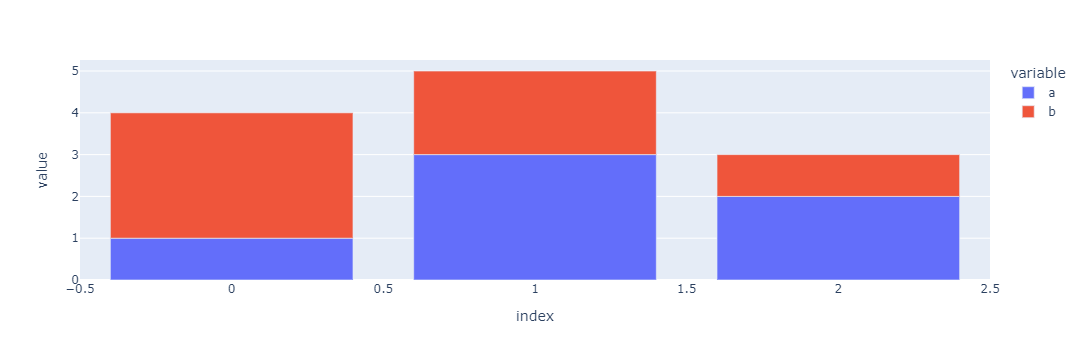

In [17]:
#Can I plot ANY example data frame from Pandas using Plotly Express?
df = pd.DataFrame(dict(a=[1,3,2], b=[3,2,1]))

# using Plotly Express directly
fig2 = px.bar(df)
fig2.show()

In [36]:
#select columns - sequence information
raw2 = raw1[["linear_sequence","linear_sequence_length"]]

#summary statistics
raw2.describe()

,linear_sequence_length
count,7180.000000
mean,10.082591
std,2.398926
min,4.000000
25%,9.000000
50%,9.000000
75%,10.000000
max,45.000000


In [39]:
#Counts of each sequence length
count_per_seqlength = raw2.groupby(['linear_sequence_length']).count()
count_per_seqlength

,linear_sequence
linear_sequence_length,
4,1
5,1
6,1
7,5
8,237
9,4154
10,1604
11,304
12,43


In [41]:
count_per_seqlength.columns

Index(['linear_sequence'], dtype='object')

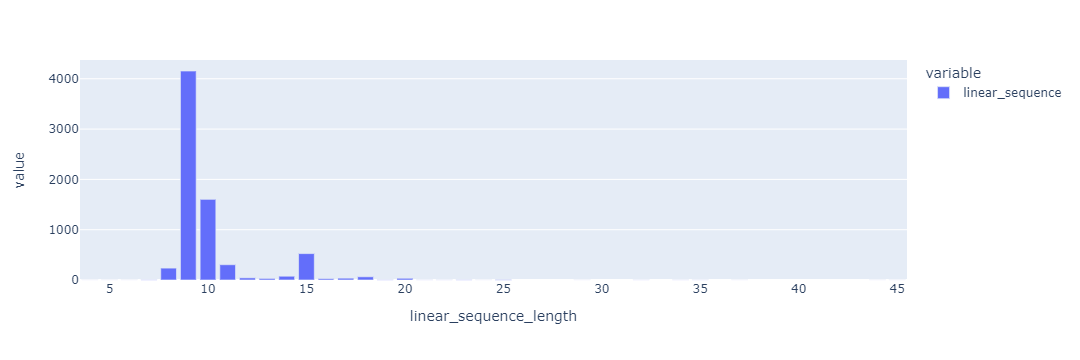

In [42]:
#Plot counts using a hisotgrame or barplot
fig = px.bar(count_per_seqlength) #Input the data frame directly, as it was converted to a dictionary, ie. plotly knows what is a key and what is value. 
fig.show()

# Basic refining 
I will not refine the plot to great details, because of time constraints and the fact that I would normally migrate to R anyway by this point

Aims:
- Define alternative axis titles
- Make all x axis breaks visible (force categorical)
- Remove the legend. It is redundant as there is only 1 variable plotted (ie. no groups to compare)

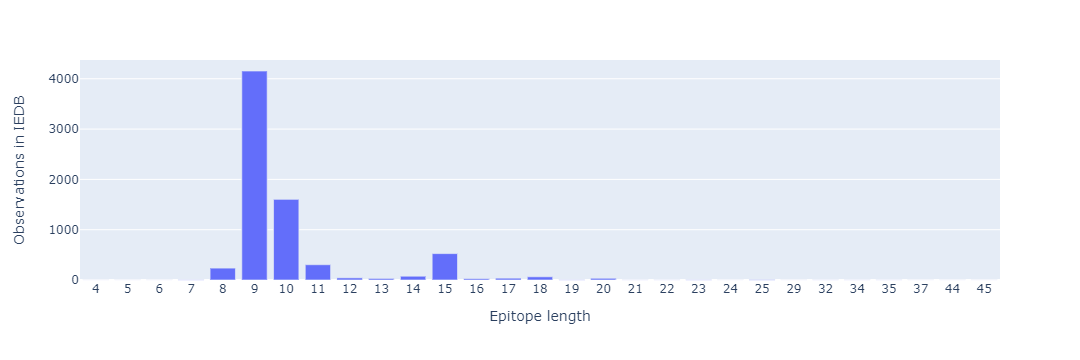

In [55]:
fig=px.bar(count_per_seqlength, labels={'linear_sequence_length':'Epitope length', "value":"Observations in IEDB"})  
fig.update_layout(showlegend=False)
fig.update_xaxes(type='category')
fig.show()

# Conclusion and afterthoughts
I have managed to:
- Interact with a API from my favorite epitope database by using a combination of bash and what I think is sql, although I did so in a very manual way by defining the url and testing ti through trial and error. 
- I managed to clean the dataframe somewhat by removing chemically modified epitopes and checking for duplicates (of which there were none). It shows that epitopes are more commonly found as 9 or 10 mers, with a noteable contribution from 15 mers. 
- I plotted a basic histogram using plotely.
- Managed everything from a github page. 

I've learned alot. Mainly, I've become better acquainted with the command line and git hub, but I have also grown somewhat sceptical of python for data visualization exclussively. R seems more streamlined, whereas Python has some many different packages that all do similarly things (matplotlib, plotely, plotely express, bokeh, altair...). Will R and ggplot be the only package that I utilize for data visualization? For now, probably! Unless I have other good reasons to use Python, the main one being that others decided that we should collaborate in Python. And if that ever happens, now I at least know what workload I can expect. 

THANK YOU FOR THE COURSE
